In [1]:
import gc
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
import spacy
import warnings

from bs4 import BeautifulSoup
from glob import glob
from typing import Callable
from typing import Dict
from typing import List
from typing import Tuple
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
tqdm.pandas()

In [140]:
nlp = spacy.load('pl_spacy_model', disable=['ner', 'parser'])
nlp_full = spacy.load('pl_spacy_model')

In [3]:
!wc -l ../PLArticlesScraper/PLArticlesScraper/scrapy_output/*.jsonl

    3809 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/bankier.jsonl
     797 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/bankier_moto.jsonl
    4702 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/bryla.jsonl
   12946 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/gazetakrakowska.jsonl
    5905 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/krakowwpigulce.jsonl
      93 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/mamstartup.jsonl
     356 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/naszemiasto.jsonl
   67651 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/nowiny24.jsonl
    5280 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/nowymarketing.jsonl
   25686 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/polki.jsonl
   29133 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/spidersweb.jsonl
   78389 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/sport.jsonl
    3536 ../PLArticlesScraper/PLArticlesScraper/scrapy_ou

In [4]:
class Utils:
    def __init__(self):
        pass
    
    def calculate_words(self, text, return_words=False):
        text = self.strip_text(text)
        text = self.clean_text(text)
        words = self.tokenize_text(text)
        number_of_words = len(words)
        if return_words:
            return number_of_words, words
        return number_of_words
    
    def remove_html_elements(self, text, elements_to_preserve=None):
        pass
    
    def strip_text(self, text):
        if text:
            text = " ".join(text).strip().split() if isinstance(text, list) else "".join(text).strip().split()
            return text
        return ""
    
    def hide_numbers(self, text):
        text = re.sub("[0-9]+", " <num> ", str(text)) # hides numbers
        return re.sub("\s+", ' ', str(text)) # remove whitespaces
    
    def clean_text(self, text):
        text = BeautifulSoup(text).get_text(strip=True).replace('\xa0', ' ') # remove html entities
        text = re.sub("(\\t|\\r|\\n)", ' ', str(text)) # tab or newline chars
        text = re.sub("(\{.*\})|(\[.*\])", '', str(text)) # matches curly braces and brackets with text inside
        text = re.sub("(__+|-+|~+|\+\++|\.\.+|\-\s+|\:+|)", ' ', str(text))
        text = re.sub("\s+", ' ', str(text)) # remove whitespaces
        
        text = re.sub(r"[<>()|&©ø\[\]\'\"\`,;~*]", '', str(text))
        text = re.sub(r"[?!]", '.', str(text))
#         text = list(filter(None, text))
        return text
    
    def tokenize_text(self, text):
        return [tok.text for tok in nlp.tokenizer(text)]

In [5]:
utils = Utils()

In [6]:
class FilesReader:
    def __init__(self, data_paths: str):
        self.data_paths = data_paths
        self.files = glob(data_paths + '*')
        self.files.sort()
        self._get_file_names()
        self.data = None
        
    def _get_file_names(self):
        self.file_names = [
            os.path.basename(file).split('.')[0]
            for file in self.files
        ]
        
    def read_json_lines_files(self) -> None:
        self.data = dict(zip(
            self.file_names, 
            (pd.DataFrame(self._read_json_lines_file(file)) for file in self.files),
        ))
        
    def _read_json_lines_file(self, file: str) -> list:
        list_of_lines = []
        with open(file, 'r', encoding='utf-8') as opened_file:
            for line in opened_file:
                list_of_lines.append(json.loads(line.rstrip('\n|\r')))
        return list_of_lines

In [291]:
class LengthFilterer:
    MIN_MAX_LENGTH = (5, 100)
    
    def __init__(
        self, 
        title_lead_length_limit: Tuple[int, int]=MIN_MAX_LENGTH, 
        text_length_limit: Tuple[int, int]=MIN_MAX_LENGTH, 
        reset_index: bool=True,
    ):
        self.title_lead_length_limit = title_lead_length_limit
        self.text_length_limit = text_length_limit
        self.column_types = ['header', 'text']
        self.default_header_columns = ['title', 'lead']
        self.default_text_columns = ['text']
        self.reset_index=True
        self.set_conditions(title_lead_length=title_lead_length_limit, text_length=text_length_limit)
        
    def get_default_columns(self, skip_title: bool=True) -> Dict[str, List[str]]:
        header_columns = self.default_header_columns
        if skip_title:
            header_columns = [header for header in self.default_header_columns if header != 'title']
        return dict(zip(self.column_types, (header_columns, self.default_text_columns)))
    
    def get_default_conditions(self) -> Dict[str, Callable]:
        return dict(zip(self.column_types, self.conditions)) 
    
    def get_default_lengths(self) -> Dict[str, Tuple[int, int]]:
        return dict(zip(self.column_types, (self.title_lead_length_limit, self.text_length_limit))) 
    
    def set_conditions(
        self, 
        title_lead_length: Tuple[int, int]=MIN_MAX_LENGTH, 
        text_length: Tuple[int, int]=MIN_MAX_LENGTH,
    ) -> None:
        self.conditions = [
            self.set_condition(title_lead_length), self.set_condition(text_length)
        ]
        
    def set_condition(self, length: Tuple[int, int]) -> Callable:
        return lambda x: max(length[0], 1) <= len(" ".join(x).strip().split()) \
            if isinstance(x, list) else max(length[0], 1) <= len(x.strip().split())
    
    def join_sentences(self, sentences, lemmatize):
        return " ".join([sent.lemma_ if lemmatize else sent.text for sent in sentences])
    
    def trim_text_to_limit_length(self, sentences, max_length, lemmatize=True):
        parsed = nlp_full(" ".join(sentences))
        cumulative_sentence_lengths = np.cumsum([sent.__len__() for sent in list(parsed.sents)])
        if len(parsed) > max_length:
            last_sentence_index = next(i for i, length in enumerate(cumulative_sentence_lengths) if length > max_length)
            return self.join_sentences(list(parsed.sents)[:last_sentence_index], lemmatize)
        else:
            return self.join_sentences(list(parsed.sents), lemmatize)
        
    def trim_column_text(self, data, column_type):
        return data.progress_map(lambda x: self.trim_text_to_limit_length(x, self.get_default_lengths()[column_type][1]))

    
    def filter_site_data(
        self, 
        data: pd.DataFrame, 
        columns_types_and_names: Dict[str, List[str]]=None, 
        conditions: Dict[str, Callable]=None,
        skip_title: bool=True,
    ) -> pd.DataFrame:
        if not columns_types_and_names:
            columns_types_and_names = self.get_default_columns()
        if not conditions:
            conditions = self.get_default_conditions()

        for column_type, column_names in tqdm(columns_types_and_names.items()):
            column_condition = conditions[column_type]
            for column_name in column_names:
                data = data[data[column_name].map(column_condition)]
                data[column_name] = self.trim_column_text(data[column_name], column_type)
        if self.reset_index:
            return data.reset_index(drop=True)
        return data

In [8]:
class TextFilterer:
    def __init__(self, columns_to_skip=['url'], columns_to_merge=None, columns_to_drop_at=None):
        self.columns_to_merge = columns_to_merge
        self.columns_to_skip = columns_to_skip
        self.columns_to_drop_at = columns_to_drop_at
        
    def unify_columns_format(self, column_data) -> pd.Series:
        column_data.fillna("", inplace=True)
        if isinstance(column_data[0], str):
            column_data = column_data.apply(lambda x : [x])
        return column_data
    
    def clean_column_data(self, column_data) -> list:
        return [list(filter(None, [
                utils.clean_text(text)
                for text in single_cell
            ]))
            for single_cell in tqdm(column_data, desc='Cleaning column')
        ]
    
    def merge_columns(self, data, column_name) -> list:
        result = data[self.columns_to_merge[column_name]] + data[column_name]
        return result
        
    def filter_site_data(self, df: pd.DataFrame) -> pd.DataFrame:
        data = df.copy(deep=True)
        for column_name in tqdm(data.columns.drop(self.columns_to_skip)):
            data[column_name] = self.unify_columns_format(data[column_name])

        for column_name in tqdm(data.columns.drop(self.columns_to_skip), desc='For column:'):
            if self.columns_to_merge and column_name in self.columns_to_merge.keys():
                data[self.columns_to_merge[column_name]] = self.merge_columns(data, column_name)
                data.drop(columns=[column_name], inplace=True)
                continue
            data[column_name] = self.clean_column_data(data[column_name])
            if self.columns_to_drop_at and column_name in self.columns_to_drop_at:
                data = data[data[column_name].map(lambda x: len(x) > 0)]
        data.reset_index(drop=True, inplace=True)
        return data
        
    def remove_lead_from_text(self, row):
        elements_to_remove = [
            idx for idx, element in enumerate(row.text) if element in row.lead 
        ]
        for idx in reversed(elements_to_remove):
            del row.text[idx]
        return row.text

    def separate_lead_from_text(self, data, file_names):
        for file_name in tqdm(file_names, desc='Article group'):
            for it, row in data[file_name][['lead', 'text']].iterrows():
                if bool(set(row.lead) & set(row.text)):
                    self.remove_lead_from_text(row)

In [9]:
file_reader = FilesReader(data_paths='../PLArticlesScraper/PLArticlesScraper/scrapy_output/')

In [10]:
file_reader.read_json_lines_files()

# Filter annd clean data

In [11]:
columns_to_merge = {
    'text_list': 'text', 
    'text_main_points': 'text',
}

In [12]:
textFilterer = TextFilterer(columns_to_merge=columns_to_merge, columns_to_drop_at=['title', 'lead', 'text'])

In [13]:
data_filtered = {}
for site in tqdm(file_reader.file_names):
    print(site)
    data_filtered[site] = textFilterer.filter_site_data(file_reader.data[site])

bankier




bankier_moto




bryla




gazetakrakowska




krakowwpigulce




mamstartup




naszemiasto




nowiny24




nowymarketing




polki




spidersweb




sport




strefainwestorow




sztukaarchitektury




wirtualnemedia_biznes




wnp


In [14]:
textFilterer.separate_lead_from_text(data_filtered, file_reader.file_names)

In [ ]:
gc.collect()

## Merge and save
Merge and save filtered and cleaned data

In [15]:
for file_name in data_filtered.keys():
    data_filtered[file_name].to_pickle('../data/filtered_data/filtered_data_' + file_name + '.pkl')

In [259]:
data_filtered = {}
for file_name in file_reader.file_names:
    data_filtered[file_name] = pd.read_pickle('../data/filtered_data/filtered_data_' + file_name + '.pkl')

In [70]:
def merge_data(dataframe, file_names):
    dfs = []
    for site in file_names:
        df = dataframe[site].copy(deep=True)
        df['site'] = site
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)
    return df_all

In [71]:
data_all = merge_data(
    dataframe=data_filtered, 
    file_names=file_reader.file_names, 
)

In [72]:
data_all.to_pickle('../data/filtered_data/polish_articles.pkl')

## Plot histograms
Plot histograms of data length prior to trimming

In [87]:
class Plotter:
    def __init__(self):
        pass
    
    def plot_data_for_columns(self, data, file_names, column, bins=25, max_percentile=1, x_limit=None, normalize=False, alpha=0.8):
        plt.figure(figsize=(16, 8))
        for i, file_name in enumerate(file_names):
            file_dataframe = data[file_name]
            file_dataframe = file_dataframe[file_dataframe[column].map(lambda x: len(utils.strip_text(x))) < \
                file_dataframe[column].map(lambda x: len(utils.strip_text(x))).quantile(max_percentile)
            ]
            try:
                file_dataframe.applymap(lambda x: len(utils.strip_text(x)))[column].plot.hist(
                    bins=bins, title=f'Length of {column}s', label=file_name, legend=True, logy=True, 
                    density=1 if normalize else None, color=plt.cm.tab20(i), alpha=alpha
                )
            except TypeError:
                continue
        plt.show()
        
    def plot_data_for_single_column(self, data, file_names, column, bins=25, max_percentile=1, x_limit=None, normalize=False):
        for i, file_name in enumerate(file_names):
            plt.figure(figsize=(12, 5))
            file_dataframe = data[file_name]
            file_dataframe = file_dataframe[file_dataframe[column].map(lambda x: len(utils.strip_text(x))) < \
                file_dataframe[column].map(lambda x: len(utils.strip_text(x))).quantile(max_percentile)
            ]
            try:
                file_dataframe.applymap(lambda x: len(utils.strip_text(x)))[column].plot.hist(
                    bins=bins, title=f'Length of {column}s', label=file_name, legend=True, logy=False, 
                    density=1 if normalize else None, color=plt.cm.tab20(i), alpha=1
                )
            except TypeError:
                continue
            plt.show()

In [88]:
plotter = Plotter()

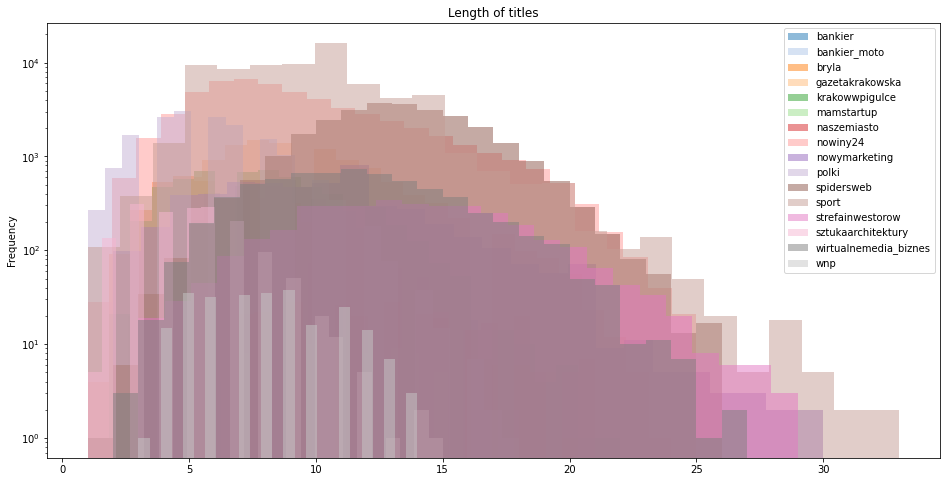

In [89]:
plotter.plot_data_for_columns(data_filtered, file_reader.file_names, column='title', max_percentile=1, alpha=.5)

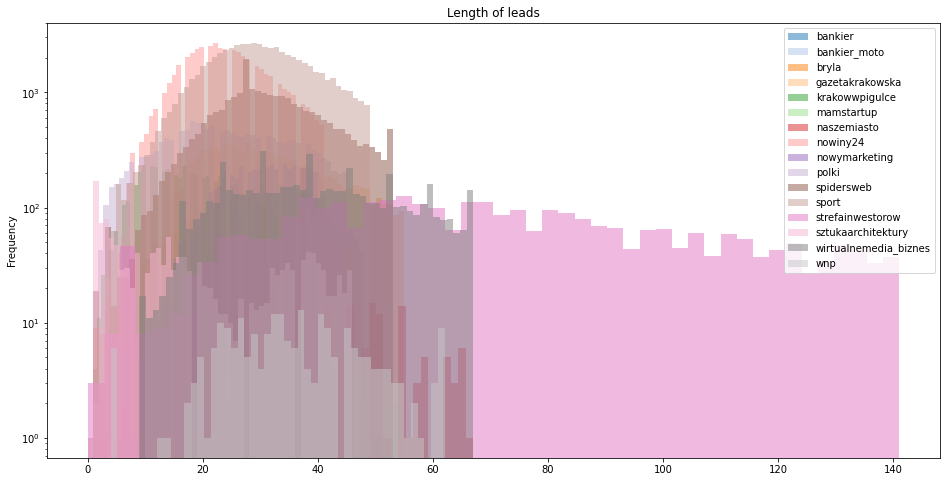

In [90]:
plotter.plot_data_for_columns(data_filtered, file_reader.file_names, bins=50, column='lead', max_percentile=.9, alpha=.5)

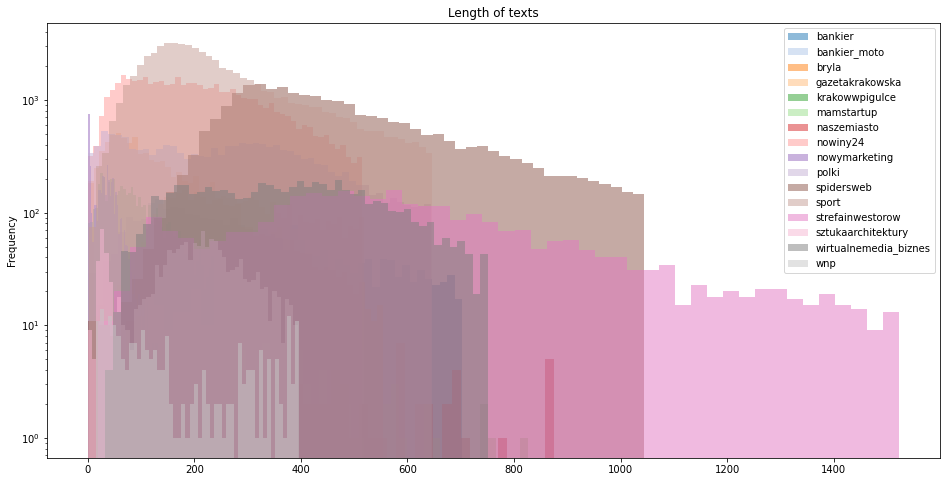

In [91]:
plotter.plot_data_for_columns(data_filtered, file_reader.file_names, bins=50, column='text', max_percentile=.9, alpha=.5)

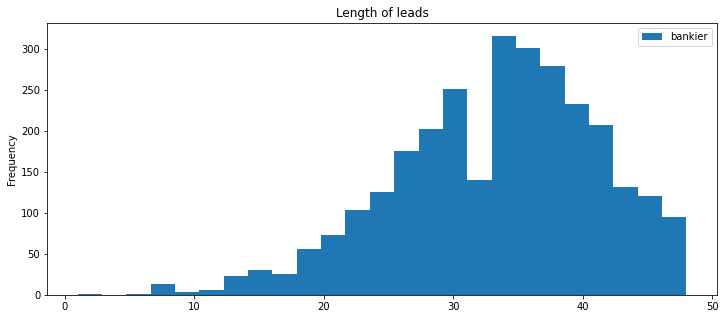

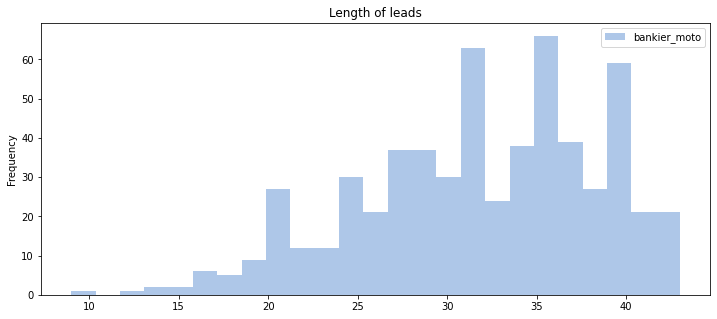

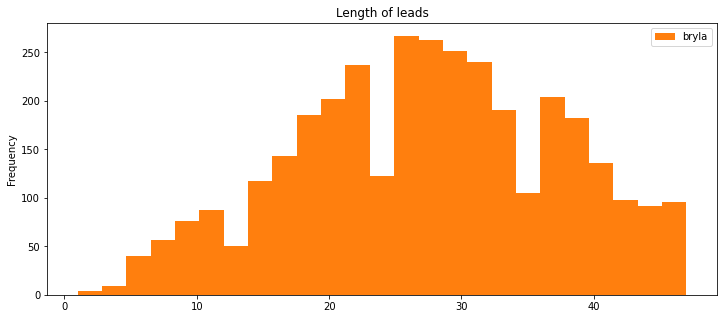

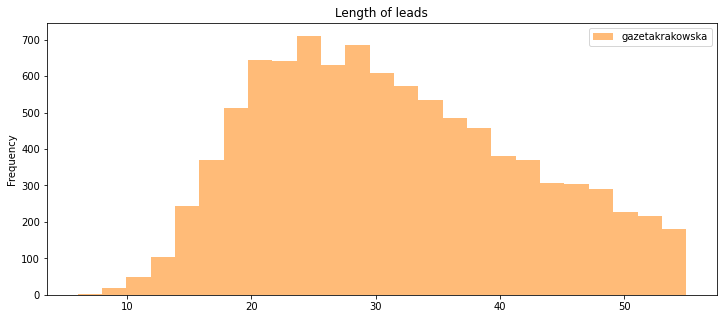

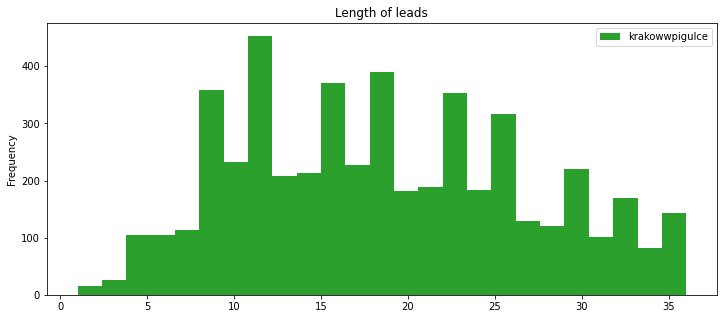

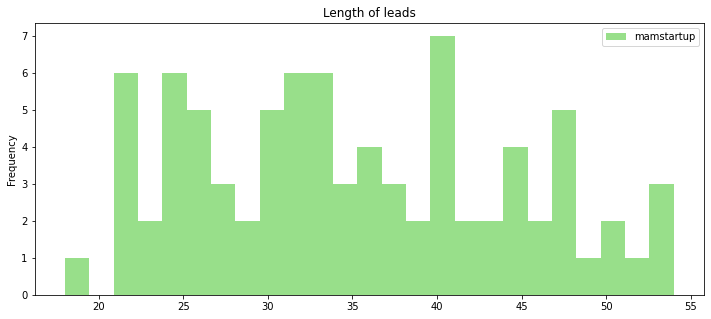

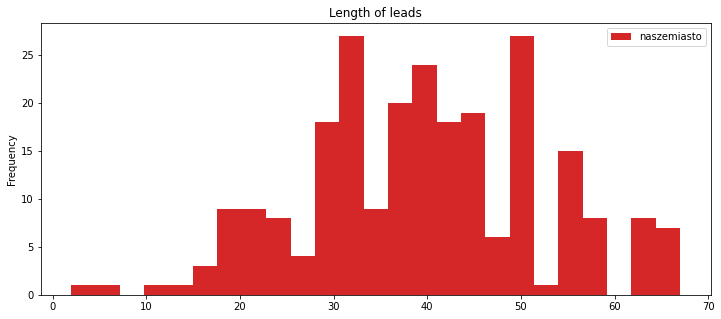

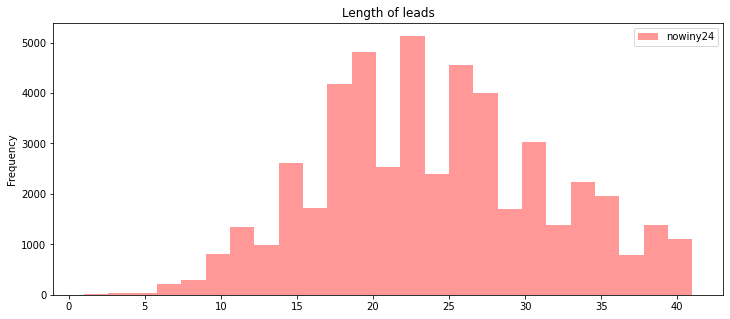

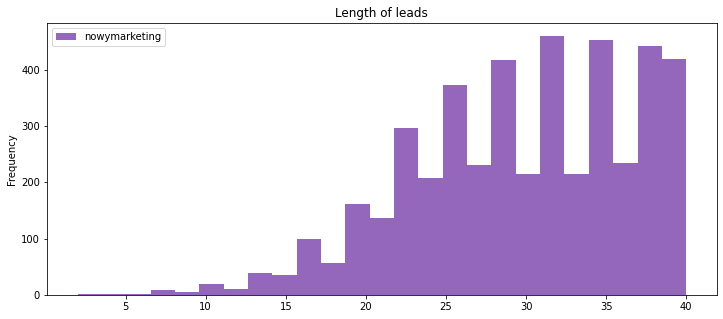

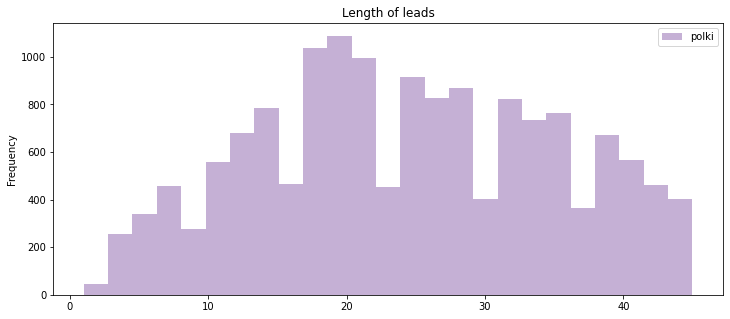

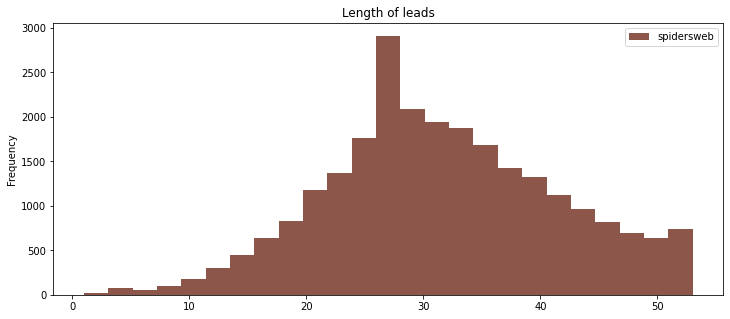

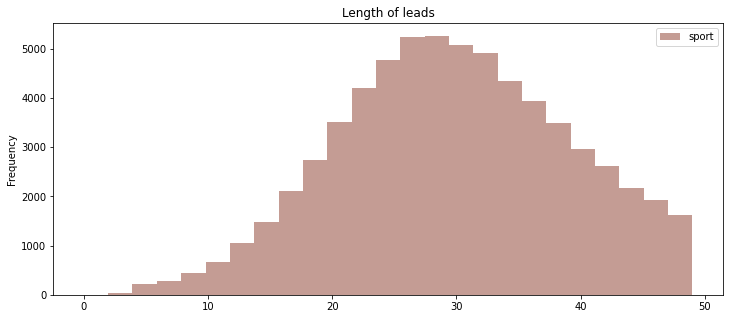

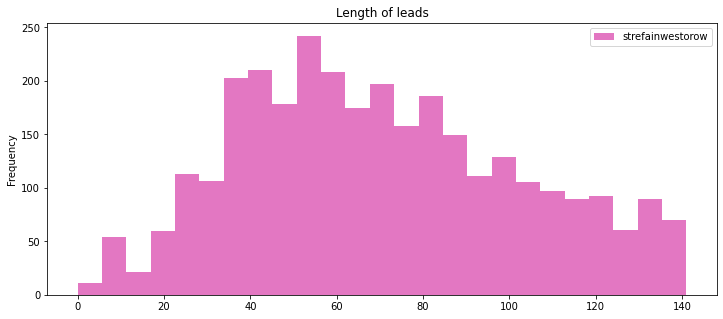

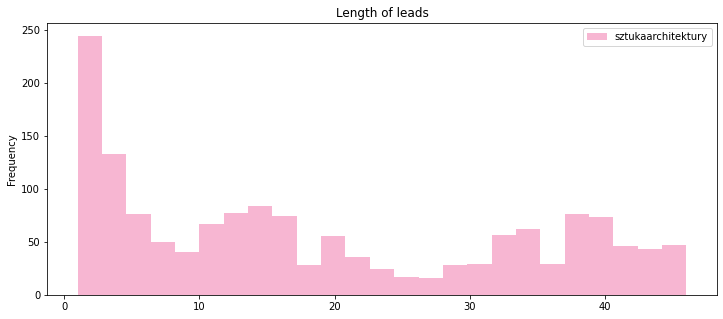

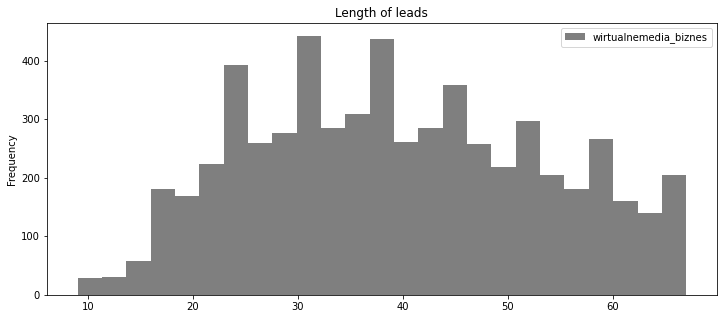

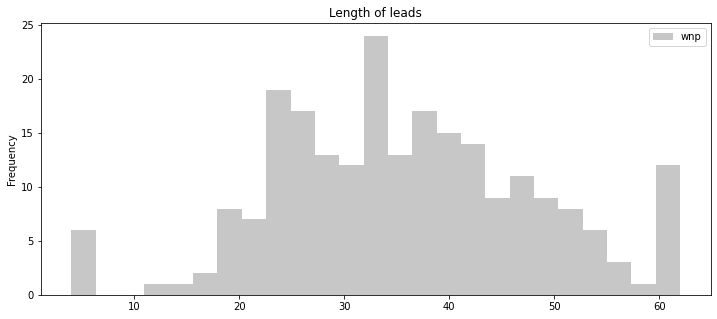

In [93]:
plotter.plot_data_for_single_column(data_filtered, file_reader.file_names, column='lead', max_percentile=.9)

# Trim data 
Trim data by length of texts
Trimming is performed only on **lead** and **text** columns

In [302]:
lengthFilterer = LengthFilterer(title_lead_length_limit=(10, 100), text_length_limit=(40, 500))

In [293]:
test_filtered = lengthFilterer.filter_site_data(data_filtered['gazetakrakowska'])
test_filtered.head()

,url,title,lead,text
0,https://gazetakrakowska.pl/jordanow-w-nocy-spl...,[Jordanów. W nocy spłonął tartak. Niemal 70 st...,nocny pożar w Jordanów w powiat suski . w płom...,ogień zostać zauważyć o godz. 3.30 w noc . na ...
1,https://gazetakrakowska.pl/koronawirus-w-nowym...,[Koronawirus w Nowym Sączu. Wracający z zagran...,sądeczanin który wracać do dom z zagranica mus...,wiele sądeczanin pracować zagranica w związek ...
2,https://gazetakrakowska.pl/krakow-trwa-budowa-...,[Kraków. Trwa budowa wodnego placu zabaw w par...,postępywać praca związane z budowa wodny plac ...,wodny plac zabawa w park Jordan to jeden z zad...
3,https://gazetakrakowska.pl/koronawirus-tarnow-...,[Koronawirus Tarnów. Wracający z zagranicy nie...,mieszkaniec Tarnów i region który planować pow...,pani Katarzyn spod Tarnów pracować dotąd w wie...
4,https://gazetakrakowska.pl/koronawirus-francis...,[Koronawirus. Franciszkanie z Krakowa zachęcaj...,w trakt walka z epidemia koronawirusa w Polska...,powstawać różny inicjatywa jak wspierać ten kt...


### Max length of trimmed data

In [303]:
test_filtered.applymap(lambda x: len(" ".join(x).strip().split()) if isinstance(x, list) else len(x.strip().split())).max()

url        1
title     20
lead      81
text     500
dtype: int64

### Min length of trimmed data

In [299]:
test_filtered.applymap(lambda x: len(" ".join(x).strip().split()) if isinstance(x, list) else len(x.strip().split())).min()

url       1
title     4
lead     20
text     76
dtype: int64

In [304]:
data_trimmed = {}
for file_name in file_reader.file_names:
    data_trimmed[file_name] = lengthFilterer.filter_site_data(data_filtered[file_name])

In [ ]:
gc.collect()

In [305]:
for file_name in data_trimmed.keys():
    data_trimmed[file_name].to_pickle('../data/filtered_data/trimmed_data_' + file_name + '.pkl')

## Merge and save
Merge and save trimmed data

In [306]:
data_all_trimmed = merge_data(
    dataframe=data_trimmed, 
    file_names=file_reader.file_names, 
)

In [307]:
data_all_trimmed

,url,title,lead,text,site
0,https://www.bankier.pl/wiadomosc/UOKiK-chce-za...,[UOKiK chce zawieszenia spłaty kredytów. KNF T...,komisja nadzór finansowy traktować propozycja ...,analizować on teraz z punkt widzenie odpowiedn...,bankier
1,https://www.bankier.pl/wiadomosc/Oszust-probow...,[Oszust próbował wyłudzić pieniądze „na żołnie...,w Zabrze woj śląski oszust próbować wyłudzić p...,na szczęście przebywać w dom kobieta zorientow...,bankier
2,https://www.bankier.pl/wiadomosc/Banknoty-500-...,[Banknoty o nominale 500 zł w powszechnym obiegu],banknot o nominalny 500 złoty znajdywać się w ...,jak czytać na strona nbp banknot 500 złoty nal...,bankier
3,https://www.bankier.pl/wiadomosc/ZUS-Swiadczen...,[ZUS Świadczenie chorobowe dla osób powracając...,osoba objąć obowiązkowy kwarantanna po przekro...,osoba który przekraczać granica państwowy mieć...,bankier
4,https://www.bankier.pl/wiadomosc/Posel-PiS-zak...,[Poseł PiS zakażony koronawirusem],pochodzić z Podsarnie na Orawa poseł pis Edwar...,poseł czuć się w miara dobrze . zarazić się pe...,bankier
...,...,...,...,...,...
200524,https://www.wnp.pl/gazownictwo/gazprom-ma-wiel...,[Gazprom ma wielki problem. Gaz się przestał s...,tylko 19 milion m3 gaz sprzedać podczas ostatn...,elektroniczny platforma sprzedaż mieć spowodow...,wnp
200525,https://www.wnp.pl/budownictwo/dane-planistycz...,[Dane planistyczne będą powszechnie dostępne],jak poinformować 13 marzec ministerstwo rozwój...,zmiana zostać zaprojektować z myśl o przyspies...,wnp
200526,https://www.wnp.pl/energetyka/cieplownictwo/se...,[Sefako ma pełny portfel zamówień],portfel zamówienie na 2020 r. mieć już praktyc...,przypomnieć że w połów grudzień 2019 r. dotycz...,wnp
200527,https://www.wnp.pl/energetyka/cieplownictwo/wa...,[Warszawa Awaria ciepłownicza na Pradze Północ...,w piątka wieczór na warszawski Praha północ na...,jako pierwszy o zdarzenie poinformować portal ...,wnp


In [308]:
data_all_trimmed.to_pickle('../data/filtered_data/polish_articles_trimmed.pkl')

## Plot histograms
Plot histograms of trimmed data length

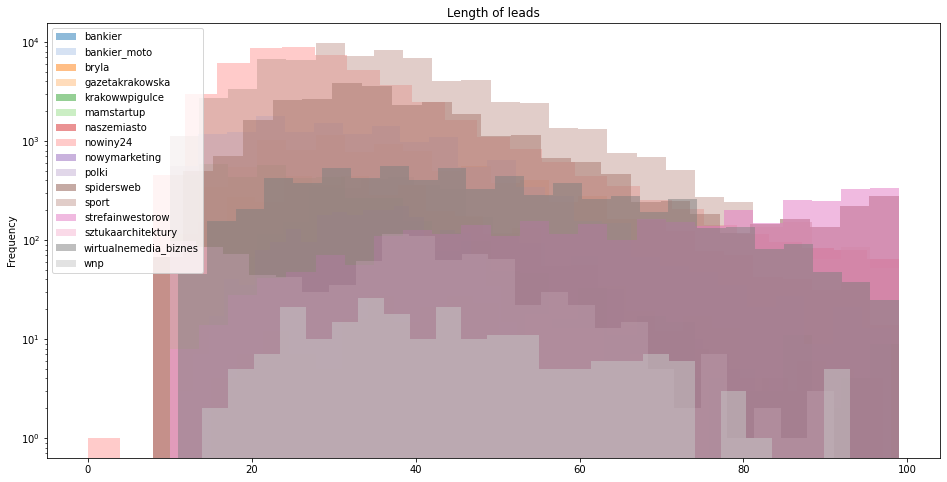

In [309]:
plotter.plot_data_for_columns(data_trimmed, file_reader.file_names, column='lead', max_percentile=1, alpha=.5)

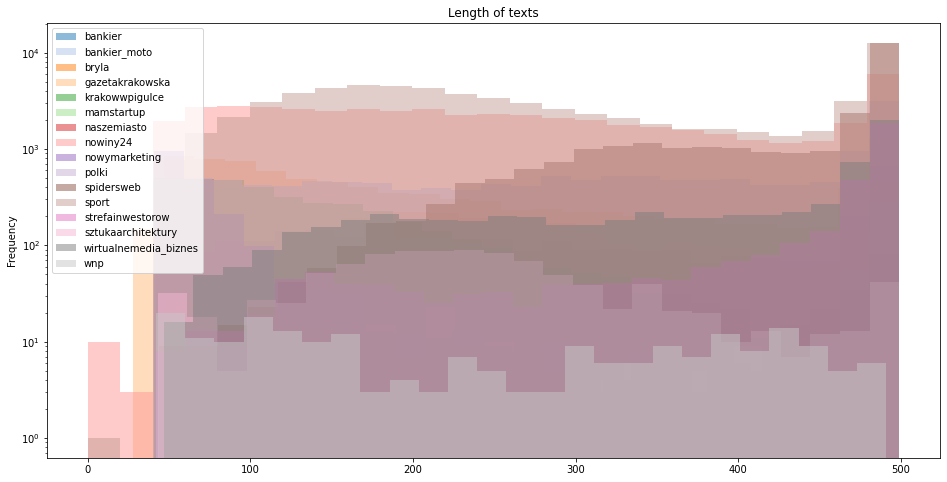

In [310]:
plotter.plot_data_for_columns(data_trimmed, file_reader.file_names, column='text', max_percentile=1, alpha=.5)